In [64]:
##Reference: https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb

import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
##Load data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


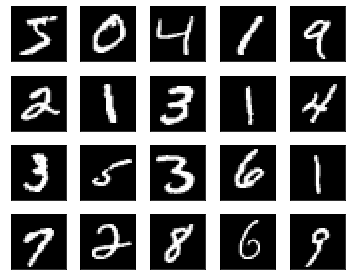

In [91]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

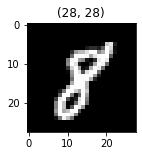

In [92]:
sample = X_train[17]

plt.figure(figsize=(3, 2))
plt.title(sample.shape)
plt.imshow(sample, cmap='gray')
plt.show()

In [93]:
X_train.min(), X_train.max()


(0, 255)

In [94]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [95]:
make_latent_samples(1, 100) # generates one sample

array([[-0.82906689,  0.9372025 ,  0.64652015, -0.13344364,  1.01752165,
        -0.04494888, -0.29088734,  0.09862649,  0.71500746,  0.32565676,
         0.45933121,  1.35244664, -2.31869552, -0.31217311,  0.90708079,
        -0.17627174,  1.76961955,  0.94395038,  1.04905636,  0.87441306,
        -1.68211191,  1.49211711, -0.41069122, -0.29602455, -2.04878965,
        -0.25102288,  1.24457019, -0.80430082,  0.51641972,  0.94937639,
         1.11540155, -0.6749229 ,  0.55325279,  1.30878971,  1.74354305,
         0.5104994 ,  0.0559175 ,  0.6481254 , -0.43794247,  0.64015233,
         1.36091042,  0.5775742 ,  1.55198059,  0.94783518, -0.50802893,
         0.44959252, -1.20199745, -0.34890782, -0.9157353 ,  1.07489165,
        -0.96690342,  1.25368004,  0.53147453,  1.6602952 , -0.910661  ,
         1.39553265, -0.40257055, -1.23167017,  0.44760343,  2.05257881,
         0.26954926, -0.29682543, -0.61190315,  1.37243208, -0.81953902,
         0.33042244, -0.63196151,  0.64514472, -0.0

In [96]:
generator = Sequential([
    Dense(128, input_shape=(100,)),
    LeakyReLU(alpha=0.01),
    Dense(784),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_2 (Activation)    (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [97]:
discriminator = Sequential([
    Dense(128, input_shape=(784,)),
    LeakyReLU(alpha=0.01),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [98]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 784)               114064    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 214,673
Non-trainable params: 0
_________________________________________________________________


In [99]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [100]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 0
Non-trainable params: 100,609
_________________________________________________________________


In [101]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [102]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(784,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [103]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [104]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [105]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

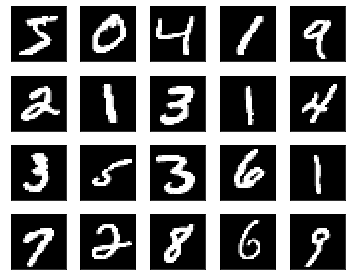

In [106]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(X_train_real[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [107]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [108]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10


(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

Epoch:   1/100 Discriminator Loss: 0.4257 Generator Loss: 2.4423
Epoch:   2/100 Discriminator Loss: 0.2955 Generator Loss: 1.6107
Epoch:   3/100 Discriminator Loss: 0.1875 Generator Loss: 3.3921
Epoch:   4/100 Discriminator Loss: 0.4850 Generator Loss: 1.2133
Epoch:   5/100 Discriminator Loss: 0.7710 Generator Loss: 5.2346
Epoch:   6/100 Discriminator Loss: 0.3406 Generator Loss: 4.3818
Epoch:   7/100 Discriminator Loss: 0.3247 Generator Loss: 3.5409
Epoch:   8/100 Discriminator Loss: 0.2062 Generator Loss: 2.4122
Epoch:   9/100 Discriminator Loss: 0.3747 Generator Loss: 2.5633
Epoch:  10/100 Discriminator Loss: 0.3101 Generator Loss: 2.7969


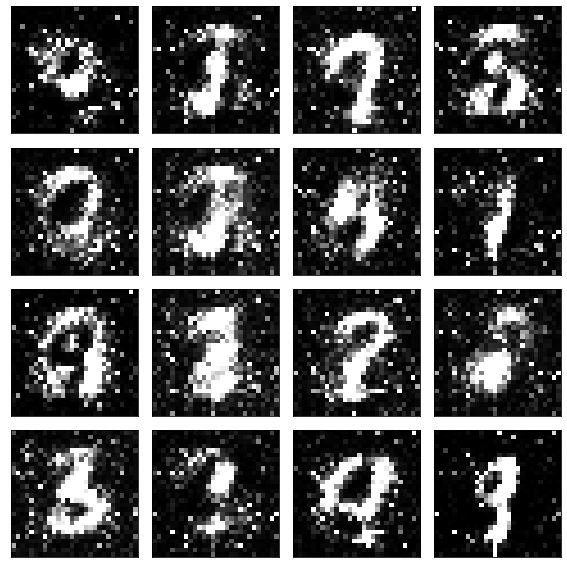

Epoch:  11/100 Discriminator Loss: 0.2281 Generator Loss: 2.7795
Epoch:  12/100 Discriminator Loss: 0.3085 Generator Loss: 3.6319
Epoch:  13/100 Discriminator Loss: 0.4317 Generator Loss: 1.5138
Epoch:  14/100 Discriminator Loss: 0.4960 Generator Loss: 5.2835
Epoch:  15/100 Discriminator Loss: 0.4142 Generator Loss: 2.3720
Epoch:  16/100 Discriminator Loss: 0.6325 Generator Loss: 1.3489
Epoch:  17/100 Discriminator Loss: 0.2398 Generator Loss: 2.3922
Epoch:  18/100 Discriminator Loss: 0.3188 Generator Loss: 3.5172
Epoch:  19/100 Discriminator Loss: 0.2115 Generator Loss: 2.6009
Epoch:  20/100 Discriminator Loss: 0.4551 Generator Loss: 2.5508


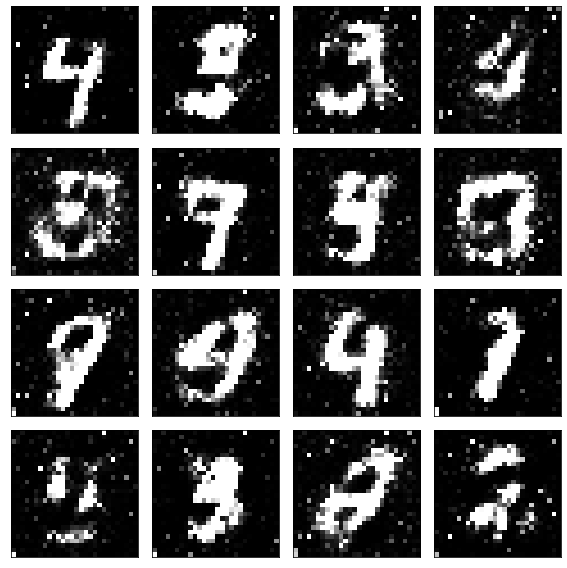

Epoch:  21/100 Discriminator Loss: 0.3610 Generator Loss: 3.1037
Epoch:  22/100 Discriminator Loss: 0.4677 Generator Loss: 3.2688
Epoch:  23/100 Discriminator Loss: 0.7214 Generator Loss: 2.4383
Epoch:  24/100 Discriminator Loss: 0.4891 Generator Loss: 3.1253
Epoch:  25/100 Discriminator Loss: 0.5680 Generator Loss: 2.9673
Epoch:  26/100 Discriminator Loss: 0.1173 Generator Loss: 3.8330
Epoch:  27/100 Discriminator Loss: 0.3159 Generator Loss: 2.2740
Epoch:  28/100 Discriminator Loss: 0.4417 Generator Loss: 3.4651
Epoch:  29/100 Discriminator Loss: 0.5202 Generator Loss: 2.5379
Epoch:  30/100 Discriminator Loss: 0.6538 Generator Loss: 2.6127


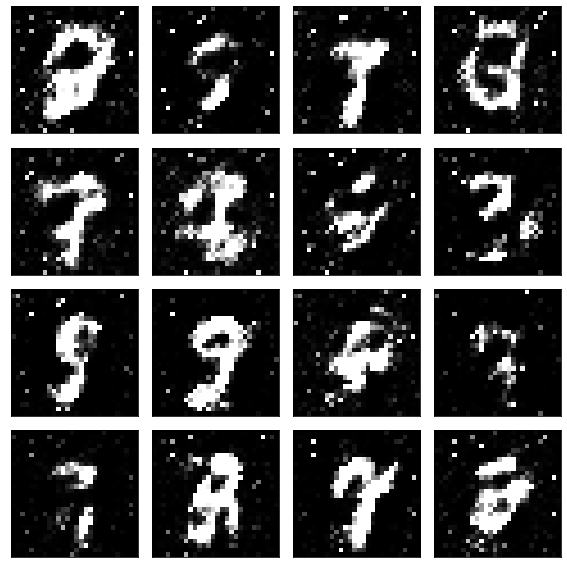

Epoch:  31/100 Discriminator Loss: 0.4563 Generator Loss: 2.1842
Epoch:  32/100 Discriminator Loss: 0.2987 Generator Loss: 3.1277
Epoch:  33/100 Discriminator Loss: 0.4325 Generator Loss: 2.5880
Epoch:  34/100 Discriminator Loss: 0.7118 Generator Loss: 2.6915
Epoch:  35/100 Discriminator Loss: 0.3751 Generator Loss: 2.0555
Epoch:  36/100 Discriminator Loss: 0.3864 Generator Loss: 2.4922
Epoch:  37/100 Discriminator Loss: 0.3837 Generator Loss: 2.1500
Epoch:  38/100 Discriminator Loss: 0.3793 Generator Loss: 3.4097
Epoch:  39/100 Discriminator Loss: 0.3844 Generator Loss: 3.0155
Epoch:  40/100 Discriminator Loss: 0.4032 Generator Loss: 3.6912


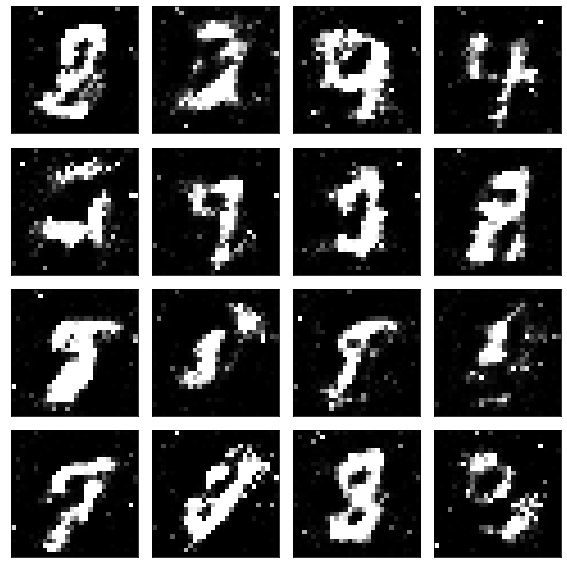

Epoch:  41/100 Discriminator Loss: 0.6805 Generator Loss: 1.9488
Epoch:  42/100 Discriminator Loss: 1.2397 Generator Loss: 2.6077
Epoch:  43/100 Discriminator Loss: 0.6143 Generator Loss: 2.1557
Epoch:  44/100 Discriminator Loss: 0.3240 Generator Loss: 3.4684
Epoch:  45/100 Discriminator Loss: 0.8905 Generator Loss: 1.8640
Epoch:  46/100 Discriminator Loss: 0.5009 Generator Loss: 2.5552
Epoch:  47/100 Discriminator Loss: 0.4453 Generator Loss: 3.1970
Epoch:  48/100 Discriminator Loss: 0.5239 Generator Loss: 2.8699
Epoch:  49/100 Discriminator Loss: 0.4376 Generator Loss: 3.4049
Epoch:  50/100 Discriminator Loss: 0.3988 Generator Loss: 2.5301


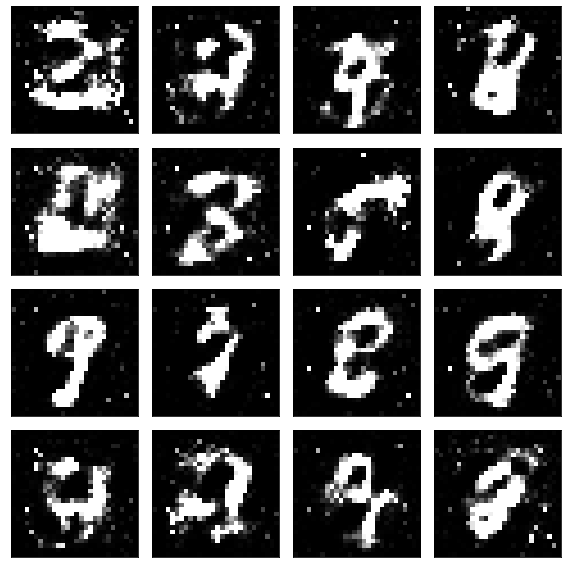

Epoch:  51/100 Discriminator Loss: 0.6136 Generator Loss: 2.6938
Epoch:  52/100 Discriminator Loss: 0.7688 Generator Loss: 2.3411
Epoch:  53/100 Discriminator Loss: 0.5740 Generator Loss: 2.1878
Epoch:  54/100 Discriminator Loss: 0.7094 Generator Loss: 2.5121
Epoch:  55/100 Discriminator Loss: 0.6344 Generator Loss: 2.0662
Epoch:  56/100 Discriminator Loss: 0.6202 Generator Loss: 2.0162
Epoch:  57/100 Discriminator Loss: 0.6822 Generator Loss: 1.6255
Epoch:  58/100 Discriminator Loss: 0.4797 Generator Loss: 2.4343
Epoch:  59/100 Discriminator Loss: 0.5414 Generator Loss: 2.3801
Epoch:  60/100 Discriminator Loss: 0.7315 Generator Loss: 2.6326


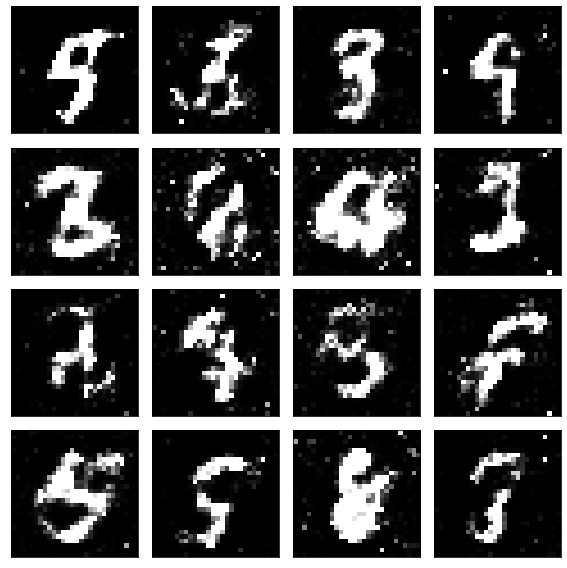

Epoch:  61/100 Discriminator Loss: 0.2604 Generator Loss: 3.9946
Epoch:  62/100 Discriminator Loss: 0.5881 Generator Loss: 2.6671
Epoch:  63/100 Discriminator Loss: 0.3742 Generator Loss: 3.6047
Epoch:  64/100 Discriminator Loss: 0.7809 Generator Loss: 3.3761
Epoch:  65/100 Discriminator Loss: 0.5612 Generator Loss: 2.7697
Epoch:  66/100 Discriminator Loss: 0.4084 Generator Loss: 3.6790
Epoch:  67/100 Discriminator Loss: 0.5857 Generator Loss: 3.2810
Epoch:  68/100 Discriminator Loss: 0.7064 Generator Loss: 2.6885
Epoch:  69/100 Discriminator Loss: 0.5173 Generator Loss: 3.2122
Epoch:  70/100 Discriminator Loss: 0.6610 Generator Loss: 3.3105


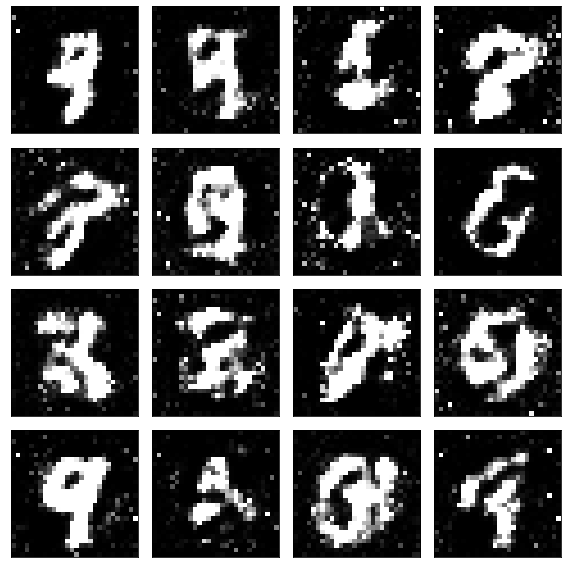

Epoch:  71/100 Discriminator Loss: 1.1008 Generator Loss: 2.9195
Epoch:  72/100 Discriminator Loss: 0.8113 Generator Loss: 2.5099
Epoch:  73/100 Discriminator Loss: 0.4496 Generator Loss: 2.3712
Epoch:  74/100 Discriminator Loss: 0.6603 Generator Loss: 2.9789
Epoch:  75/100 Discriminator Loss: 1.0832 Generator Loss: 3.6462
Epoch:  76/100 Discriminator Loss: 0.7810 Generator Loss: 3.1270
Epoch:  77/100 Discriminator Loss: 0.6630 Generator Loss: 2.9391
Epoch:  78/100 Discriminator Loss: 0.8167 Generator Loss: 3.9317
Epoch:  79/100 Discriminator Loss: 0.7969 Generator Loss: 3.6460
Epoch:  80/100 Discriminator Loss: 0.9952 Generator Loss: 3.3776


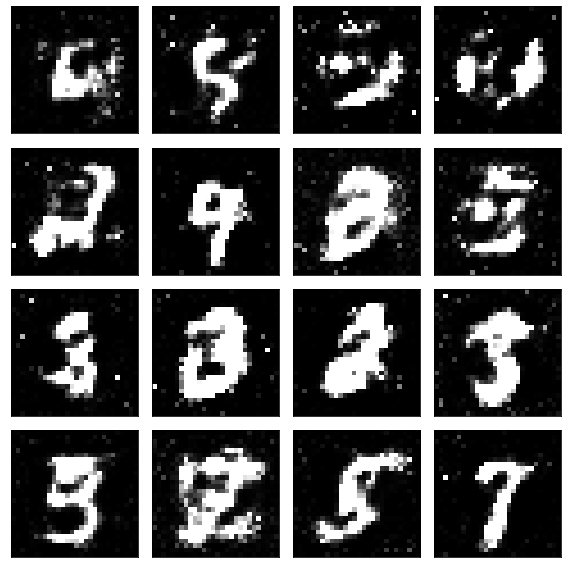

Epoch:  81/100 Discriminator Loss: 0.6594 Generator Loss: 2.7735
Epoch:  82/100 Discriminator Loss: 0.9193 Generator Loss: 2.7690
Epoch:  83/100 Discriminator Loss: 0.7851 Generator Loss: 3.2709
Epoch:  84/100 Discriminator Loss: 0.3346 Generator Loss: 2.8014
Epoch:  85/100 Discriminator Loss: 0.5418 Generator Loss: 3.4622
Epoch:  86/100 Discriminator Loss: 0.9475 Generator Loss: 3.2780
Epoch:  87/100 Discriminator Loss: 0.6076 Generator Loss: 2.7057
Epoch:  88/100 Discriminator Loss: 0.8147 Generator Loss: 2.8834
Epoch:  89/100 Discriminator Loss: 0.9569 Generator Loss: 3.0579
Epoch:  90/100 Discriminator Loss: 0.6087 Generator Loss: 2.9006


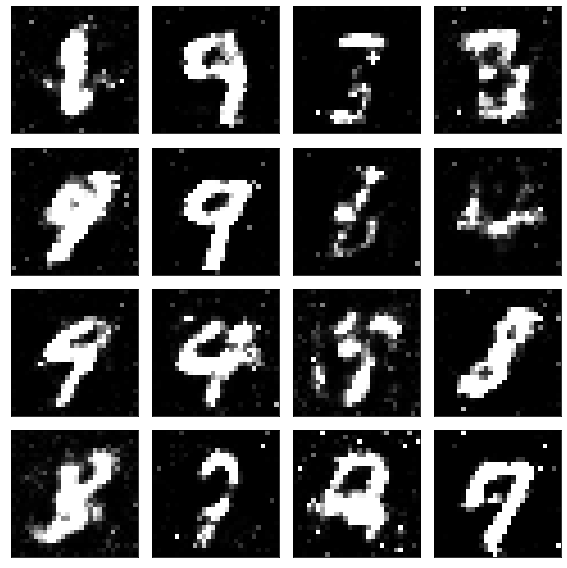

Epoch:  91/100 Discriminator Loss: 0.7559 Generator Loss: 2.1452
Epoch:  92/100 Discriminator Loss: 0.5407 Generator Loss: 3.1311
Epoch:  93/100 Discriminator Loss: 0.7423 Generator Loss: 2.5619
Epoch:  94/100 Discriminator Loss: 0.6971 Generator Loss: 2.6414
Epoch:  95/100 Discriminator Loss: 1.0604 Generator Loss: 2.7426
Epoch:  96/100 Discriminator Loss: 0.5018 Generator Loss: 2.6423
Epoch:  97/100 Discriminator Loss: 0.6015 Generator Loss: 3.0264
Epoch:  98/100 Discriminator Loss: 0.4859 Generator Loss: 2.3942
Epoch:  99/100 Discriminator Loss: 0.5488 Generator Loss: 2.2820
Epoch: 100/100 Discriminator Loss: 0.7830 Generator Loss: 2.3092


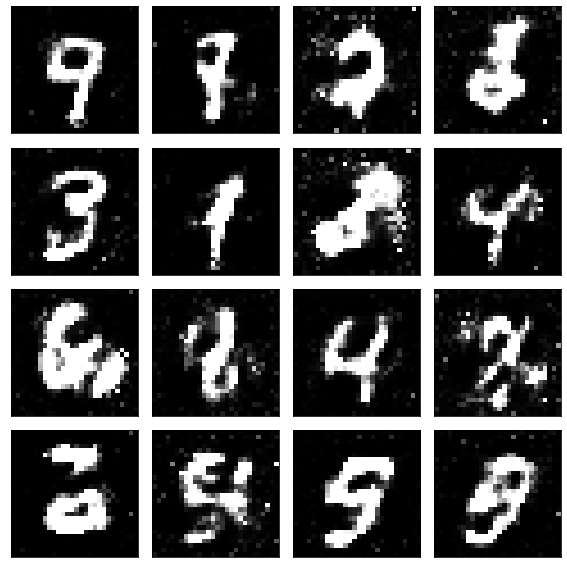

In [109]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)


# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))
        
    if (e+1) % 10 == 0:
        generated_digits = generator.predict(latent_samples)
        plt.figure(figsize=(8, 8))
        for i in range(16):
            img = deprocess(generated_digits[i])
            plt.subplot(4, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.savefig('GANimage/post_images_%d.png' % e+1)
        plt.show()

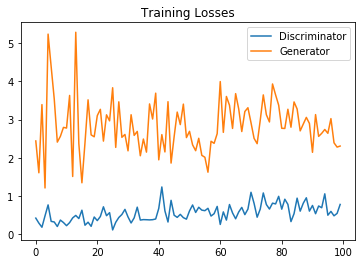

In [114]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.savefig('GANimage/losses.png')
plt.show()

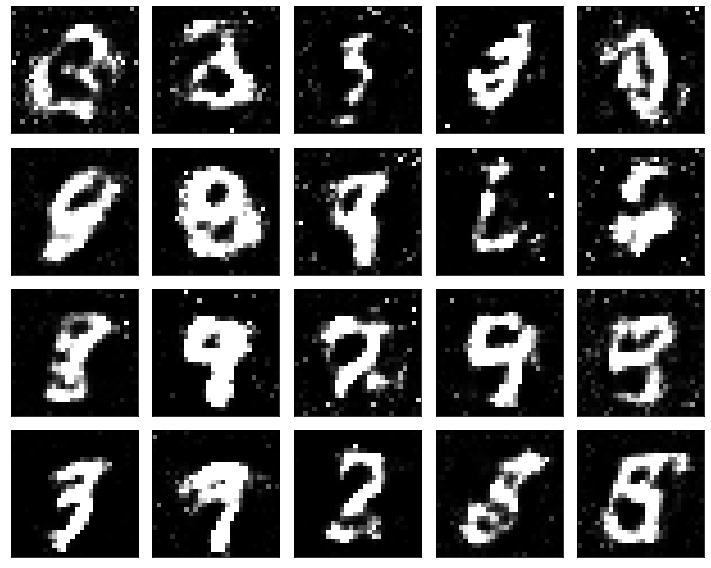

In [111]:


latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig('post_images.png')
plt.show()